In [30]:
# imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.utils import shuffle
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

In [31]:
# Mount Google Drive
drive.mount('/content/drive')
# Change to the ICBHI2024 directory on my Google Drive
os.chdir('/content/drive/MyDrive/ICBHI2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Augmentation functions
def add_noise(data, noise_factor=0.5):
    noise = np.random.randn(*data.shape) * noise_factor
    return data + noise

def scale_data(data, scale_factor=1.2):
    return data * scale_factor

def time_warp(data, sigma=0.2):
    if len(data.shape) != 3:
        raise ValueError("Data shape is not compatible for time warping.")
    warped_data = np.zeros_like(data)
    for trial in range(data.shape[0]):
        for region in range(data.shape[1]):
            orig_steps = np.arange(data.shape[2])
            random_warp = np.random.normal(loc=1.0, scale=sigma, size=data.shape[2])
            warp_steps = np.cumsum(random_warp) / np.sum(random_warp) * (data.shape[2] - 1)
            cs = CubicSpline(orig_steps, data[trial, region, :])
            warped_data[trial, region, :] = cs(warp_steps)
    return warped_data

def jitter(data, sigma=0.05):
    return data + np.random.normal(loc=0.0, scale=sigma, size=data.shape)

# Function to augment data
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)

        augmented_data.append(add_noise(sample))
        augmented_labels.append(label)

        augmented_data.append(scale_data(sample))
        augmented_labels.append(label)

        augmented_data.append(time_warp(sample[np.newaxis, ...]).squeeze(0))
        augmented_labels.append(label)

        augmented_data.append(jitter(sample))
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# Function to load data from npz files
def load_npz_data(fpath):
    all_data = np.load(fpath)
    return all_data['data']

# Function to load brain region names from a file
def load_brain_regions(atlas_path):
    brain_regions = {}
    with open(atlas_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            index, region = line.strip().split('\t')
            brain_regions[int(index)] = region
    return brain_regions

# Function to slice fMRI data into baseline, video, and rating segments
def slice_fMRI_data(data):
    baseline = data[:, 0:5]  # Last 5 seconds of the fixation cross
    video = data[:, 5:20]    # 15 seconds of the video
    rating = data[:, 20:25]  # First 5 seconds after the end of the video
    return baseline, video, rating

# Function to extract features from fMRI data
def extract_fmri_features(fmri_data, brain_regions):
    features = []
    for trial in range(fmri_data.shape[0]):  # Iterate through each trial
        _, video_data, _ = slice_fMRI_data(fmri_data[trial])

        trial_features = []
        for region in range(len(brain_regions)):  # Iterate through each region
            var_video = np.var(video_data[region])

            region_features = [
                region,  # Region number
                var_video
            ]
            trial_features.extend(region_features)
        features.append(trial_features)
    return np.array(features)

# Function to load participant data
def load_participants_data(data_dir, brain_regions, augment_data_flag=False, labels_present=True):
    subjects = sorted([s for s in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, s))])
    all_fmri_data = []
    all_labels = []
    subject_names = []

    print(f"Loading data from {data_dir}...")
    for subject in tqdm(subjects):
        if subject.startswith('.'):
            continue  # skip hidden files like .DS_Store

        subject_path = os.path.join(data_dir, subject)
        fMRI_data_path = os.path.join(subject_path, 'fMRI_data.npz')

        if os.path.exists(fMRI_data_path):
            fMRI_data = load_npz_data(fMRI_data_path)
            print(f"Subject {subject} fMRI data shape: {fMRI_data.shape}")

            all_fmri_data.append(fMRI_data)
        else:
            print(f"Missing data for {subject}")

        if labels_present:
            labels_path = os.path.join(subject_path, 'labels.npz')
            if os.path.exists(labels_path):
                labels = load_npz_data(labels_path)[:, 0].astype(int)  # Only take the class label
                print(f"Subject {subject} labels shape: {labels.shape}")
                all_labels.append(labels)
            else:
                print(f"Missing labels for {subject}")

        # Track the subject names
        subject_names.append(subject)

    # Combine all data and labels from all subjects
    all_fmri_data = np.concatenate(all_fmri_data, axis=0)
    print(f"All fMRI data shape after concatenation: {all_fmri_data.shape}")
    all_labels = np.concatenate(all_labels, axis=0) if labels_present and all_labels else None
    if all_labels is not None:
        print(f"All labels shape after concatenation: {all_labels.shape}")

    if augment_data_flag and all_labels is not None:
        all_fmri_data, all_labels = augment_data(all_fmri_data, all_labels)

    # Extract features after augmentation
    all_fmri_features = extract_fmri_features(all_fmri_data, brain_regions)
    print(f"All fMRI features shape after feature extraction: {all_fmri_features.shape}")

    if labels_present and all_labels is not None:
        return {'fmri_features': all_fmri_features, 'labels': all_labels, 'subject_names': subject_names}
    else:
        return {'fmri_features': all_fmri_features, 'subject_names': subject_names}

# Example usage:
atlas_path = 'data/Supplementary/BN_atlas.txt'
train_data_dir = 'data/Train'
test_data_dir = 'data/Test'

brain_regions = load_brain_regions(atlas_path)
train_data = load_participants_data(train_data_dir, brain_regions, augment_data_flag=True, labels_present=True)
test_data = load_participants_data(test_data_dir, brain_regions, augment_data_flag=False, labels_present=False)

print(train_data.keys())
print(test_data.keys())
print(train_data['fmri_features'].shape)
print(train_data['labels'].shape)
print(test_data['fmri_features'].shape)


Loading data from data/Train...


 31%|███▏      | 5/16 [00:00<00:00, 44.61it/s]

Subject P01 fMRI data shape: (30, 246, 25)
Subject P01 labels shape: (30,)
Subject P02 fMRI data shape: (30, 246, 25)
Subject P02 labels shape: (30,)
Subject P03 fMRI data shape: (30, 246, 25)
Subject P03 labels shape: (30,)
Subject P04 fMRI data shape: (30, 246, 25)
Subject P04 labels shape: (30,)
Subject P05 fMRI data shape: (30, 246, 25)
Subject P05 labels shape: (30,)
Subject P06 fMRI data shape: (30, 246, 25)
Subject P06 labels shape: (30,)
Subject P07 fMRI data shape: (30, 246, 25)
Subject P07 labels shape: (30,)
Subject P08 fMRI data shape: (30, 246, 25)
Subject P08 labels shape: (30,)
Subject P09 fMRI data shape: (30, 246, 25)
Subject P09 labels shape: (30,)


100%|██████████| 16/16 [00:00<00:00, 42.99it/s]

Subject P10 fMRI data shape: (30, 246, 25)
Subject P10 labels shape: (30,)
Subject P11 fMRI data shape: (30, 246, 25)
Subject P11 labels shape: (30,)
Subject P12 fMRI data shape: (30, 246, 25)
Subject P12 labels shape: (30,)
Subject P13 fMRI data shape: (30, 246, 25)
Subject P13 labels shape: (30,)
Subject P14 fMRI data shape: (30, 246, 25)
Subject P14 labels shape: (30,)
Subject P15 fMRI data shape: (30, 246, 25)
Subject P15 labels shape: (30,)
Subject P16 fMRI data shape: (30, 246, 25)
Subject P16 labels shape: (30,)
All fMRI data shape after concatenation: (480, 246, 25)
All labels shape after concatenation: (480,)


All fMRI features shape after feature extraction: (2400, 492)
Loading data from data/Test...


100%|██████████| 4/4 [00:00<00:00, 53.55it/s]

Subject P17 fMRI data shape: (30, 246, 25)
Subject P18 fMRI data shape: (30, 246, 25)
Subject P19 fMRI data shape: (30, 246, 25)
Subject P20 fMRI data shape: (30, 246, 25)
All fMRI data shape after concatenation: (120, 246, 25)


All fMRI features shape after feature extraction: (120, 492)
dict_keys(['fmri_features', 'labels', 'subject_names'])
dict_keys(['fmri_features', 'subject_names'])
(2400, 492)
(2400,)
(120, 492)


Epoch 1/100
15/15 [==============================] - 2s 55ms/step - loss: 2.1295 - accuracy: 0.3867 - val_loss: 0.9966 - val_accuracy: 0.5367
Epoch 2/100
15/15 [==============================] - 1s 37ms/step - loss: 0.9233 - accuracy: 0.5811 - val_loss: 0.8501 - val_accuracy: 0.6733
Epoch 3/100
15/15 [==============================] - 1s 37ms/step - loss: 0.7333 - accuracy: 0.7017 - val_loss: 0.5621 - val_accuracy: 0.7850
Epoch 4/100
15/15 [==============================] - 1s 37ms/step - loss: 0.4621 - accuracy: 0.8361 - val_loss: 0.3176 - val_accuracy: 0.9050
Epoch 5/100
15/15 [==============================] - 1s 38ms/step - loss: 0.2657 - accuracy: 0.9044 - val_loss: 0.1940 - val_accuracy: 0.9400
Epoch 6/100
15/15 [==============================] - 1s 38ms/step - loss: 0.1589 - accuracy: 0.9483 - val_loss: 0.1270 - val_accuracy: 0.9667
Epoch 7/100
15/15 [==============================] - 1s 37ms/step - loss: 0.1102 - accuracy: 0.9639 - val_loss: 0.0845 - val_accuracy: 0.9767
Epoch 

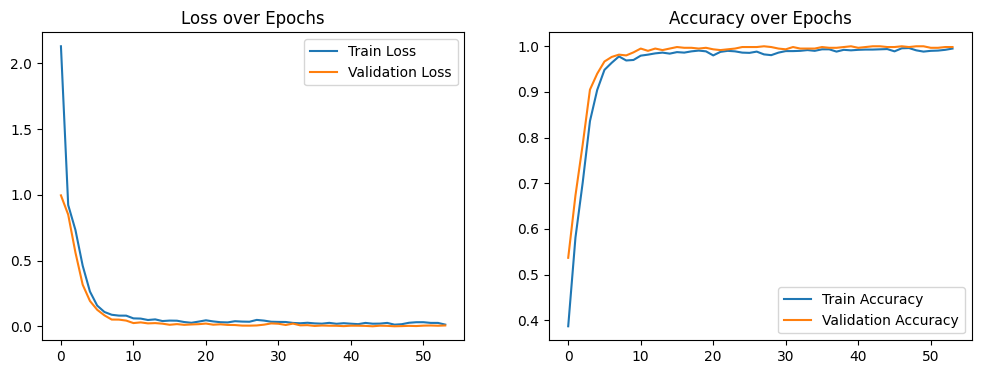

4/4 [==============================] - 0s 5ms/step


In [33]:
# Normalize the data
X_train, y_train = shuffle(train_data['fmri_features'], train_data['labels'], random_state=42)
X_test = test_data['fmri_features']

scaler = StandardScaler()
X_train = scaler.fit_transform(train_data['fmri_features'])
X_test = scaler.transform(test_data['fmri_features'])

# Prepare the labels
num_classes = 3
y_train = to_categorical(train_data['labels'], num_classes)

# Reshape data for input into Conv1D (add channel dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    # x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Create and compile the model
input_shape = (X_train.shape[1], 1)
model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.006),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

# Making predictions on the test data
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)


In [39]:
# Print the final training and validation accuracy and loss
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_accuracy}")
print(f"Final Validation Accuracy: {val_accuracy}")
print(f"Final Training Loss: {train_loss}")
print(f"Final Validation Loss: {val_loss}")


Final Training Accuracy: 0.9950000047683716
Final Validation Accuracy: 0.9983333349227905
Final Training Loss: 0.014333615079522133
Final Validation Loss: 0.00786649901419878


In [40]:
# Making predictions on the test data
predictions = model.predict(X_test)

# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# predicted_classes = predicted_classes

# # Print out subject, trial number, and prediction
for x, y in zip(predicted_classes, predictions):
    print(x, y)

# # Save predictions to a CSV file
# submission = pd.DataFrame(predicted_classes, columns=['Prediction'])
# submission.to_csv('submission.csv', index=False)

# process both of the sets at the same time
# predictions

4/4 [==============================] - 0s 5ms/step
0 [9.999693e-01 6.289077e-06 2.430368e-05]
1 [1.4113238e-06 9.9963486e-01 3.6371767e-04]
1 [0.0076365  0.97767186 0.01469146]
0 [0.8399605  0.11236808 0.04767144]
2 [5.7360015e-09 2.5228506e-09 9.9999994e-01]
0 [5.4014778e-01 4.5985168e-01 4.1978853e-07]
0 [9.9999994e-01 1.6330775e-09 6.7246438e-11]
2 [4.7587999e-03 3.0081085e-06 9.9523818e-01]
1 [1.7673407e-04 5.9170622e-01 4.0811709e-01]
0 [0.8019263  0.05589084 0.14218287]
1 [3.7164427e-04 9.0437299e-01 9.5255375e-02]
1 [0.00311417 0.6186946  0.3781912 ]
2 [2.8442577e-04 1.8817179e-02 9.8089838e-01]
2 [7.4190324e-12 1.4465918e-07 9.9999982e-01]
1 [0.02106133 0.9629738  0.015965  ]
1 [4.7429698e-05 9.9993664e-01 1.5837537e-05]
1 [1.4926633e-04 9.9984908e-01 1.7307023e-06]
2 [2.3224496e-04 2.7333257e-05 9.9974048e-01]
1 [7.8934399e-08 9.9999982e-01 4.3272239e-10]
0 [9.9999994e-01 6.8798420e-09 2.3557258e-09]
1 [1.6497624e-11 9.9999994e-01 1.7488747e-20]
2 [2.6940339e-07 2.8131775e-05 